In [1]:
import bisect
# go to the parent folder
import os

import matplotlib.pyplot as plt

os.chdir("..")

import numpy as np
import pandas as pd
import time

# Our package
from RB_method_for_model_identification.RBForModelIdentification import RBForModelIdentification

# Define the system

In this example, we consider a data set from real experiments. Potentially, the circuit can be described by a three gene-state model as follows:
\begin{align}
&\text{Gene Activation:} && G \to G^* && \text{Propensity:} ~ k_{1} X_G \\
&\text{Gene Deactivation:} && G^* \to G && \text{Propensity:} ~ k_{2} X_{G^*} \\
&\text{Gene Further activation:} && G^* \to G^{**} && \text{Propensity:} ~ k_3 X_{G^*} \\
&\text{Gene Deactivation:} && G^{**} \to G^* && \text{Propensity:} ~ k_4 X_{G^{**}} \\
&\text{mRNA Transcription:} && \emptyset \to \text{mRNA} && \text{Propensity:} ~ k_{p1} X_{G^*} + (k_{p1}+k_{p2}) X_{G^{**}}  \\
&\text{mRNA Degration:} &&\text{mRNA} \to \emptyset && \text{Propensity:} ~ k_d X_\text{mRNA} \\
\end{align}
the gene can transition between three distinct states, with mRNA being produced when the gene is in either of the two activated states. Additionally, the rate of mRNA degradation is directly proportional to its copy number. Also, the mRNA exhibits fluorescence, allowing for the use of a microscope to record its dynamics very 2 minutes.

leader species:  ['G1', 'G2']
follower species:  ['mRNA', 'G0']
follower parameters:  ['k4', 'kp1', 'k1', 'k3', 'kp2', 'k2']


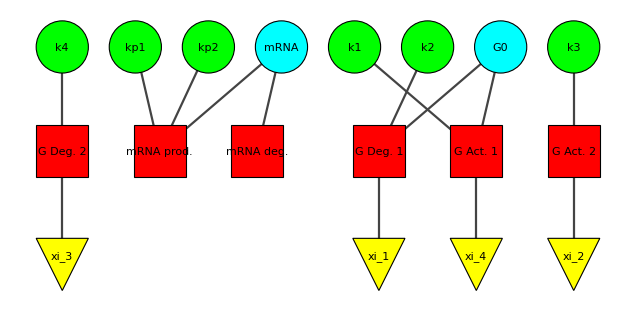

Number of subsystems: 4
-----------------------------------------------------
    xi_1  xi_2  xi_3  xi_4
G1    -1    -1     1     1
G2     0     1    -1     0
-----------------------------------------------------
Subsystem:  1
Involved parameters and species: ['k4']
Unobservable reactions involved: []
Observable reactions involved: ['G Deg. 2']
Xi involved: ['xi_3']
Size of state space of this subsystem: 21
-----------------------------------------------------
Subsystem:  2
Involved parameters and species: ['kp1', 'kp2', 'mRNA']
Unobservable reactions involved: ['mRNA prod.', 'mRNA deg.']
Observable reactions involved: []
Xi involved: []
Size of state space of this subsystem: 18271
-----------------------------------------------------
Subsystem:  3
Involved parameters and species: ['k1', 'k2', 'G0']
Unobservable reactions involved: []
Observable reactions involved: ['G Deg. 1', 'G Act. 1']
Xi involved: ['xi_1', 'xi_4']
Size of state space of this subsystem: 882
------------------------

In [2]:
# The network structure
species_names = ['G0', 'G1', 'G2', 'mRNA']
stoichiometric_matrix = [[-1, 1, 0, 0, 0, 0],
                         [1, -1, -1, 1, 0, 0],
                         [0, 0, 1,-1, 0, 0],
                         [0, 0, 0, 0, 1,-1]]
parameters_names = ['k1','k2', 'k3', 'k4', 'kp1', 'kp2']
reaction_names = ['G Act. 1', 'G Deg. 1', 'G Act. 2', 'G Deg. 2', 'mRNA prod.', 'mRNA deg.']
propensities = [
    lambda k1, G0: k1*G0,
    lambda k2, G1: k2*G1,
    lambda k3, G1: k3*G1,
    lambda k4, G2: k4*G2,
    lambda kp1, kp2, G1, G2: kp1*G1 + (kp1+kp2)*G2,
    lambda mRNA: mRNA
]

range_of_species = \
    pd.DataFrame([[0, 1], [0, 1], [0, 1], [0, 150] ], index=species_names, columns=['min', 'max'])
range_of_parameters= \
    pd.DataFrame([[0, 1], [0, 1], [0, 1], [0, 2], [20, 40], [40, 80]],index=parameters_names,columns=['min', 'max'])
discretization_size_parameters = \
    pd.DataFrame([21, 21, 21, 21, 11, 11], index=parameters_names) #index=parameters_names

# The observation related information
# h_function = [
#     lambda Protein: Protein
# ]
h_function = [
    lambda mRNA: np.where(mRNA > 7, mRNA, 0)
]
observation_noise_intensity = [
    lambda : 1
]
#observation_noise_intensity = {'sigma1': 0.1}

maximum_size_of_each_follower_subsystem = 30000 #800 # 1000


MI = RBForModelIdentification(
    species_names=species_names,
    stoichiometric_matrix=stoichiometric_matrix,
    parameters_names=parameters_names,
    reaction_names=reaction_names,
    propensities=propensities,
    range_of_species=range_of_species,
    range_of_parameters=range_of_parameters,
    observation_noise_intensity=observation_noise_intensity,
    discretization_size_parameters=discretization_size_parameters,
    h_function=h_function,
    maximum_size_of_each_follower_subsystem=maximum_size_of_each_follower_subsystem)

print('leader species: ', MI.leader_species_time_course_data)
print('follower species: ', MI.get_follower_species_time_course_data())
print('follower parameters: ', MI.get_follower_parameters_time_course_data())
MI.leader_follower_decomposition_result_time_course_data.plot_decomposition()

## Load the result

In [3]:
import pickle

# cell index = 78, 18, 20, 39 43, 51, 79, 82, 83, 87, 88, 93, 96, 107, 123, 139

cell_index = 78

# Load the objects from the pickle file
with open(f"Example_of_model_identification/results_in_paper/real_data_cell_index_{cell_index}_particle_number_3000_small_space.pkl", 'rb') as f:
    data = pickle.load(f)

# with open(f"real_data_cell_index_{cell_index}_particle_number_10000_small_space.pkl", 'rb') as f:
#     data = pickle.load(f)


# Create a new object from the dictionary
Marginal_distributions_over_time = data['margin_distributions_over_time']
time_result = data['time_result']
mean_result = data['mean_result']
std_result = data['std_result']
Y_list = data['Y_list']


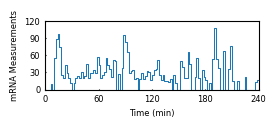

In [4]:
# plot the observation
def cm_to_inch(value):
    return value/2.54

tf =240
dt = 2
Observation_times_list = np.arange(dt, tf+dt, dt)


fig = plt.figure(figsize=(cm_to_inch(7), cm_to_inch(3)))
#plt.step(time_list, np.array(state_list)[:,3],where='post',linewidth=0.75, label='mRNA')
#plt.plot(Observation_times_list, Y_list, 'o', markersize=0.75, label='Measurements')
plt.step(Observation_times_list, Y_list,where='post',linewidth=0.75, label='mRNA')

plt.xlim((0, 240))
plt.ylim((0, 120))
xticks = np.arange(0, 241, step=60)
plt.xticks(xticks)  # Set the x-ticks
plt.xlabel('Time (min)', fontsize=6)
plt.ylabel('mRNA Measurements', fontsize=6)
plt.tick_params(axis='x', labelsize=6, direction='in', length=1)

yticks = np.arange(0, 121, step=30)
plt.yticks(yticks)
plt.tick_params(axis='y', labelsize=6, direction='in', length=1)

#plt.legend(loc='upper right', fontsize=6)

plt.subplots_adjust(bottom=0.3)

#plt.tight_layout()  # This will ensure everything fits in the figure area

# Save the figure as an EPS file
fig.savefig("figure.eps", format='eps')

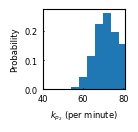

In [5]:
# plot marginal distributions

parameter_species_names = MI.parameters_names + MI.species_names
marginal_distributions = sorted(Marginal_distributions_over_time[-1], key=lambda x: parameter_species_names.index(next(iter(x.parameter_species_ordering))))


# something to change for different plot
marginal_distribution = marginal_distributions[5]
name_to_show = '$k_{p_2}$'


distribution = marginal_distribution.distribution_list[-1].copy()
states = marginal_distribution.states.copy()
name = list(marginal_distribution.parameter_species_ordering.keys())[0]


fig = plt.figure(figsize=(cm_to_inch(3), cm_to_inch(3)))

plt.bar(states.reshape(-1), distribution.reshape(-1), width=states[1] - states[0], label='Estimated distribution')
# plt.axvline(x=parameter_values[name], color='r', linestyle='--', label='real value')

plt.xlabel(name_to_show +' (per minute)', fontsize=6)
plt.ylabel('Probability', fontsize=6)

plt.tick_params(axis='x', labelsize=6, direction='in', length=1)
plt.tick_params(axis='y', labelsize=6, direction='in', length=1)



if name in ['k1', 'k2', 'k3']:
    xticks = np.arange(0, 1.1, step=0.5)
    plt.xlim((0-0.025, 1+0.025))
    #yticks = np.arange(0, 0.91, step=0.3)
elif name in ['k4']:
    xticks = np.arange(0, 2.1, step=1)
    plt.xlim((0-0.1, 1+0.1))
    yticks = np.arange(0, 0.21, step=0.1)
elif name in ['kp1']:
    xticks = np.arange(20, 41, step=10)
    plt.xlim((20, 41))
    #yticks = np.arange(0, 0.61, step=0.2)
    yticks = np.arange(0, 0.51, step=0.2)
else:
    xticks = np.arange(40, 81, step=20)
    plt.xlim((40, 81))
    yticks = np.arange(0, 0.21, step=0.1)

if name in ['k1', 'k2', 'k4']:
    yticks = np.arange(0, 0.16, step=0.05)
elif name in ['k3']:
    yticks = np.arange(0, 0.31, step=0.1)


plt.xticks(xticks)  # Set the x-ticks
plt.yticks(yticks)  # Set the x-ticks




# plt.legend(loc='upper left', fontsize=6)



plt.subplots_adjust(bottom=0.2, left= 0.2)



fig.savefig("figure.eps", format='eps', bbox_inches='tight')

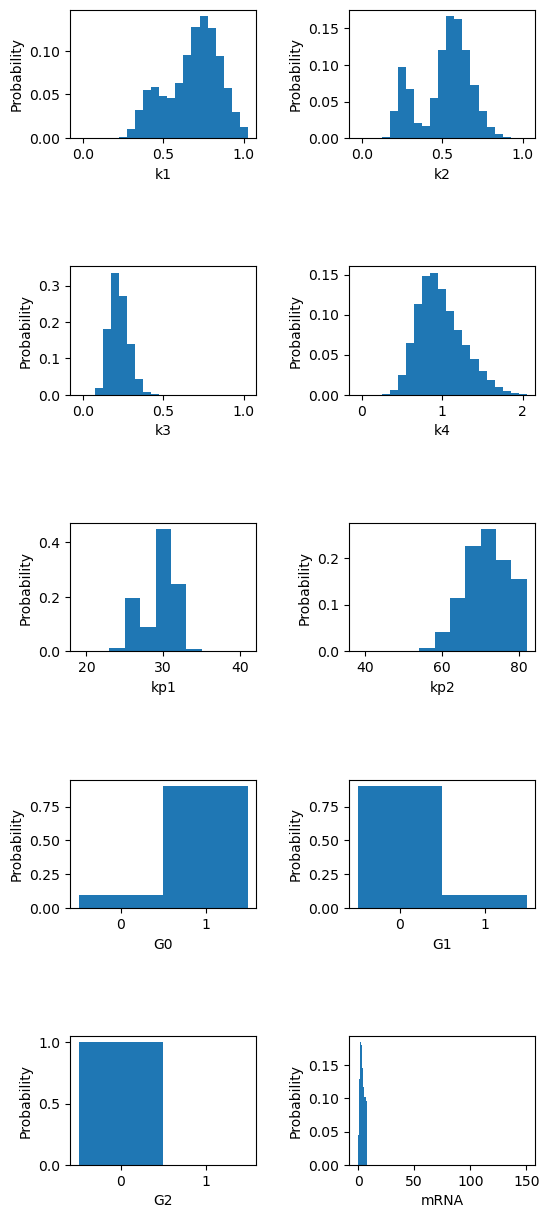

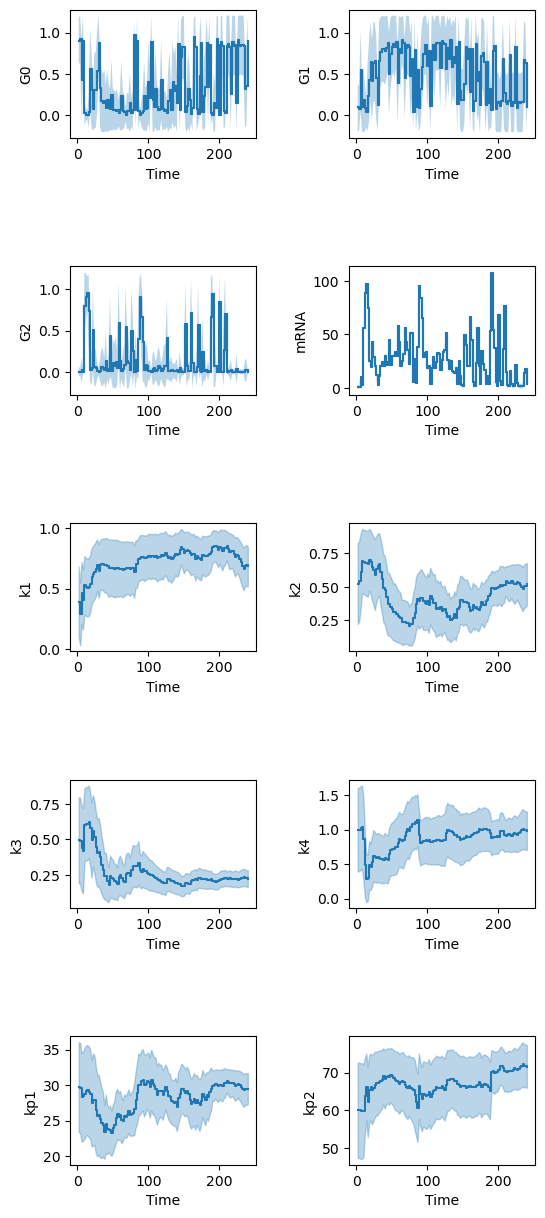

In [6]:
# plot marginal distributions
MI.plot_marginal_distribution(Marginal_distributions_over_time[-1])
# MI.plot_marginal_distribution(Particles_list_returned[-1], parameter_real_values=parameter_values)

# plot the estimate over time
MI.plot_mean_std_estimates_over_time(time_result, mean_result, std_result)

In [22]:
# compute the stationary distribution of the infreed model

from CRN_Simulation.MarginalDistribution import MarginalDistribution
Initial_marginal_distributions = MI.generate_uniform_marginal_distributions_via_speceis_range(MI.range_of_species)
delta_distribution = np.zeros((len(Initial_marginal_distributions['mRNA'].states), 1))
delta_distribution[0] = 1
Initial_marginal_distributions['mRNA'].adjust_distribution(delta_distribution)
# initial distribution of G0, G1, G2
Initial_marginal_distributions['G0'].adjust_distribution(np.array([[0], [1]]))
Initial_marginal_distributions['G1'].adjust_distribution(np.array([[1], [0]]))
Initial_marginal_distributions['G2'].adjust_distribution(np.array([[1], [0]]))

MAP_parameter_dict = {}
for i in range(len(Marginal_distributions_over_time[-1])):
    element = list(Marginal_distributions_over_time[-1][i].parameter_species_ordering.keys())[0]
    if element in MI.parameters_names:
        map_index = np.argmax(Marginal_distributions_over_time[-1][i].distribution_list[-1])
        map_state = Marginal_distributions_over_time[-1][i].states[map_index, 0]
        MAP_parameter_dict.update({element: map_state})


Tf = 100
distribution_inferred_model = MI.FSP(Initial_marginal_distributions, MI.range_of_species, MAP_parameter_dict, 0, Tf, normalization=True)
marginal_distributions_over_time = distribution_inferred_model.extract_marginal_distributions_over_time()
mRNA_distribution_inferred_model = marginal_distributions_over_time[-1]['mRNA'].distribution
mRNA_distribution_inferred_model = mRNA_distribution_inferred_model.flatten()


dx = 10

bins = np.arange(0, 150, dx)
data_distribution= [0]*len(bins)
for i in range(len(bins)-1):
    for j in range(5, len(Y_list)):
        if bins[i] <= Y_list[j] < bins[i+1]:
            data_distribution[i] += 1
data_distribution = np.array(data_distribution)/sum(data_distribution)


new_distribution= [0]*len(bins)

for i in range(len(bins)-1):
    for j in range(len(mRNA_distribution_inferred_model)):
        if bins[i] <= j < bins[i+1]:
            new_distribution[i] += mRNA_distribution_inferred_model[j]

x = [x+dx/2 for x in bins]

weights = np.ones_like(Y_list) / len(Y_list)
# plt.hist(np.array(Y_list[5:]).reshape(-1), weights=weights, bins=bins, edgecolor='black', alpha=0.75, label='data')
x = [x+dx/2 for x in bins]


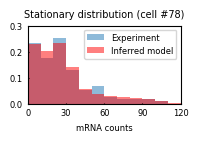

In [29]:
#fig = plt.figure(figsize=(cm_to_inch(4.5), cm_to_inch(3)))
fig = plt.figure(figsize=(cm_to_inch(5), cm_to_inch(3)))
plt.bar(x, data_distribution, width=dx, alpha=0.5, label='Experiment')

plt.bar(x, new_distribution, color='red', width=dx, alpha=0.5, label='Inferred model')
# plt.plot(x, new_distribution, color='red', label='inferred')

plt.legend(loc='upper right', fontsize=6)

plt.tick_params(axis='x', labelsize=6, direction='in', length=1)
plt.tick_params(axis='y', labelsize=6, direction='in', length=1)

plt.xlabel( 'mRNA counts', fontsize=6)
# plt.ylabel('Probability', fontsize=6)
plt.title(f'Stationary distribution (cell #{cell_index})', fontsize=7)
#plt.title(f'Stationary distribution', fontsize=7)

xticks = np.arange(0, 121, step=30)
plt.xticks(xticks)  # Set the x-ticks
plt.xlim((0, 120))
yticks = np.arange(0, 0.31, step=0.1)
plt.yticks(yticks)  # Set the x-ticks

plt.subplots_adjust(bottom=0.22)

fig.savefig("figure.pdf", format='pdf')

In [28]:
from scipy.stats import entropy

kl_divergence = entropy(data_distribution, new_distribution)
print('KL-divergence:', kl_divergence)

L1_norm = sum(abs(data_distribution - new_distribution))
print('L1 norm:', L1_norm)

KL-divergence: 0.020021506402662953
L1 norm: 0.11507080736382941
